In [125]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint

from polynomial_nets import CP_L3, CP_L3_sparse, NCP_L3, CP, Chebyshev, Chebyshev_L3

from poly_VAE import Flatten, UnFlatten, VAE_CP_L3, VAE_CP_L3_sparse, VAE_CP_L3_sparse_LU, loss_fn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

import uqtestfuns as uqtf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import poly_utils as ut 

In [126]:
#list(zip(*ind))

In [127]:
#sum_array = np.vstack(tuple(sum_list))

In [128]:
#np.unique(np.array(sum_array), axis=0)

In [129]:
dim = 8
cut1 = 3
cut2 = 3
mi1 = np.eye((dim), dtype=int)
mi2 = np.eye((dim), dtype=int)
mi1_cut1 = mi1[:cut1]
mi2_cut1 = mi2[:cut2]
mi1_cut2 = mi1[:cut1]
mi2_cut2 = mi2[:cut2]

In [130]:
mi_list1 = [mi1] + [mi2] 

In [131]:
mi_list2 = [mi1_cut] + [mi2_cut]

In [136]:
mi_f1 = ut.multi_indices_net_CP(mi_list1)
print(mi_f1.shape)

(44, 8)


In [137]:
mi_f2 = ut.multi_indices_net_CP(mi_list2)
print(mi_f2.shape)

(9, 8)


In [143]:
ut.add_multi_index(mi_f1, mi_f2).shape

(44, 8)

In [145]:
mi_list = [mi1]*6
mi_f = ut.multi_indices_net_CP(mi_list)

In [146]:
dist = np.count_nonzero(mi_f, axis=1)

In [147]:
mi3 = ut.add_multi_index(ut.prod_multi_index(mi1, mi2), mi1)

In [ ]:
mi3 = ut.multi_indices_CP

(array([  48.,  420., 1120., 1050.,  364.]),
 array([1., 2., 3., 4., 5., 6.]),
 <BarContainer object of 5 artists>)

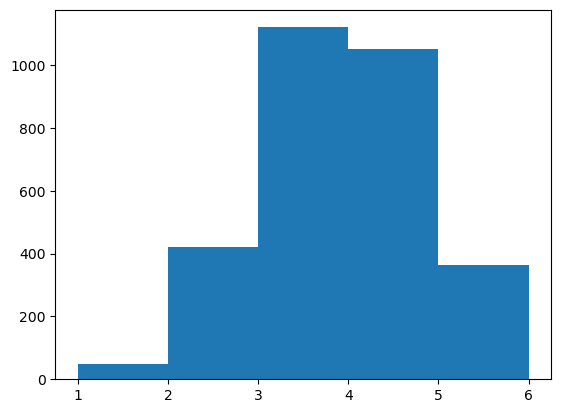

In [151]:
plt.hist(dist, bins = 5)

In [94]:
mi_sum = torch.sum(torch.tensor(mi3), dim=1)

In [95]:
len(mi_sum)

9

In [88]:
mi4 = ut.prod_multi_index(mi1, mi2)

In [11]:
len(mi4)

120

In [24]:
mi1.dtype

dtype('int64')

In [25]:
def prod_multi_index(mi1, mi2):
    sum_list = []
    for i in mi2:
        tile = np.tile(i, (len(mi1),1))
        sum = mi1 + tile
        sum_list = sum_list + [sum]
        sum_array = np.vstack(tuple(sum_list))
        mi3 = np.unique(np.array(sum_array), axis=0)
    return mi3

In [26]:
def prod_multi_index2(mi1, mi2):
    sum_list = []
    for i in mi2:
        sum = mi1 + i
        sum_list.append(sum)
    sum_array = np.vstack(tuple(sum_list))
    mi3 = np.unique(np.array(sum_array), axis=0)
    return mi3

In [27]:
mi31 = prod_multi_index(mi1, mi2)

In [28]:
mi32 = prod_multi_index2(mi1, mi2)

In [29]:
np.max(mi31 - mi32)

0

In [30]:
#mi4 = prod_multi_index(mi3, mi1)

In [31]:
#mi4

In [32]:
def add_multi_index(mi1, mi2):
    mi3 = np.unique(np.vstack((mi1, mi2)), axis=0)
    return mi3


In [33]:
mi3 = np.unique(np.vstack((mi1, mi2)), axis=0)

In [37]:
degree = 6
dimension = 50
mi1 = np.eye((dimension))
mi = mi1
for i in range(2, degree + 1):
    mi = add_multi_index(prod_multi_index2(mi, mi1), mi)
    print(i, len(mi))

2 1325
3 23425
4 316250


In [17]:
rank = 1
output_dim = 1
model = CP(degree, dimension, rank, output_dim)
model = Chebyshev(degree, dimension, rank, output_dim)

In [32]:
model.__class__

polynomial_nets.Chebyshev

In [18]:
list_p = []
for name, p in model.named_parameters():  
   if len(p.shape) == 2:
      print(p.shape)
      if p.shape[0] == rank and p.shape[1] == dimension:
         list_p = list_p + [p]
      


torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 8])
torch.Size([1, 1])


In [34]:
sparse_list = []
for p in list_p:
    mask1 = p > 0.1 
    mask2 = p < -0.1
    mask3 =  (mask1 | mask2) 
    p = mask3 * p
    sparse_list = sparse_list + [p]

In [35]:
w = sparse_list[0]
ind = torch.where(w[0] == 0)[0].numpy()
mi_w = np.eye(w.shape[1])
mi_w_s = np.delete(mi_w, ind, 0)

In [36]:
sparse_mi = []
for i in sparse_list:
    ind = torch.where(i[0] == 0)[0].numpy()
    mi_w = np.eye(i.shape[1])
    mi_w_s = np.delete(mi_w, ind, 0)
    sparse_mi = sparse_mi + [mi_w_s]


In [38]:
mi_s = sparse_mi[0]
for i in range(1, len(sparse_mi)):
    mi1 = sparse_mi[i]
    mi_s = add_multi_index(prod_multi_index2(mi_s, mi1), mi_s)
    print(i)

1


ValueError: need at least one array to concatenate

In [ ]:
if isinstance(model, Chebyshev):
   sd = model.state_dict
   sparse_param = []
   for name, p in model.named_parameters(): 
      #print(name)
      if name != 'layer_C.weight' and name != 'layer_C.bias' and name != 'T0':
         sparse_param = sparse_param + [p]
         print(name)

In [ ]:
if isinstance(model, Chebyshev):
    sparse_mi = []
    for i in sparse_param:
        ind = torch.where(i[0] == 0)[0].to('cpu').detach().numpy()
        mi_w = np.eye(i.shape[1])
        mi_w_s = np.delete(mi_w, ind, 0)
        sparse_mi = sparse_mi + [mi_w_s]


In [ ]:
if isinstance(model, Chebyshev):
    mi_list = []
    
    mi_s1 = sparse_mi[0]
    mi_s0 = np.zeros(mi_s1.shape[1])
    mi_list = mi_list + [mi_s1]
    print(mi_s0)
    for i in range(1, len(sparse_mi) + 1, 2):
        mi_s0 = add_multi_index(prod_multi_index(mi_s1, sparse_mi[i]), mi_s0)
        mi_list = mi_list + [mi_s0]
        
        if i == DEGREE - 1:
            mi_s = mi_s0
            break
        else:  
            print(i)         
            mi_s1 = add_multi_index(prod_multi_index(mi_s0, sparse_mi[i+1]), mi_s1)
            mi_list = mi_list + [mi_s1]
            mi_s = mi_s1